In [1]:
import numpy as np

# Find indices of the different peaks in the data
def findPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2))
    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices

In [21]:
from scipy.optimize import leastsq
import numpy as np

# Get one mean by fitting a Gaussian distribution to the data
# with resolution of 280000
def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]
    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))
    c = out[0]
    return c

In [33]:
from scipy.optimize import minimize
import numpy as np
from scipy.signal import find_peaks

# Calculate mean square error for the model
def MSE(x, y, a, mu, sigma):
    norm = lambda a, mu, x: a*np.exp(-0.5*((x-mu)/sigma)**2)
    error = 0
    for i in range(len(y)):
        error = error + (y[i] - np.sum(norm(a,mu,x[i])))**2
    return error/len(y)


def errorFunction(x, y, sigma):
    return lambda params: MSE(x, y, params[::2], params[1::2], sigma)

# Function used to group values that are too close (abs(mu[n]-mu[n+1])<th) to each other together
def group(mu, th):
    groups = []
    unassigned = np.linspace(0,len(mu)-1,len(mu)).astype(int)
    while len(unassigned) > 0:
        dist = abs(np.array(mu[unassigned]) - mu[unassigned[0]])
        group = unassigned[dist < th]
        unassigned = unassigned[dist >= th]
        groups += [group]
    return groups

# Get one or more means depending on if there are multiple peaks in the data
# by fitting one or more Gaussian distributions to the data using resolution of 280000 
def getMeans(peaks):
    ind = find_peaks(peaks[:,1], max(peaks[:,1])/20, prominence=max(peaks[:,1])/10)[0]
    mu = peaks[ind,0]
    n = len(mu)
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))

    init  = []
    for i in range(len(mu)):
        init += [np.mean(peaks[:,1]), mu[i]]
    
    # Fit n Gaussian distributions to the data
    if n>1:
        f = errorFunction(peaks[:,0], peaks[:,1], sigma)
        params = minimize(f, init, method='BFGS').x
    else:
        params = getMean(peaks)
    
    a = params[::2]
    mu = params[1::2]
    
    # Group fitted distributions that are too close to each other together
    # and combine them
    groups = group(mu, 1e-5)
    a2 = np.zeros(len(groups))
    mu2 = np.zeros(len(groups))
    sigma2 = np.zeros(len(groups))
    for i in range(len(groups)):
        mu2[i] = np.mean(mu[groups[i]])
        a2[i] = np.sum(a[groups[i]])
        sigma2[i] = np.mean(sigma[groups[i]])
    return mu2, a2, sigma2


In [4]:
import numpy as np

# Get all peak means for the data
def getAllMeans(peaks):
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

In [5]:
import pandas as pd
import numpy as np

# Identify peaks and return a data frame of peaks and their properties
def identifyPeaks(data, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['a'] = np.zeros(len(peaklist['mz']))
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peakMeans, a, sigmas, ind = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:
            j = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[j]
            peaklist.iloc[i,3] = a[j]
            peaklist.iloc[i,4] = sigmas[j]
            peaklist.iloc[i,5] = ind[j]
    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
    return peaklist.drop(unidentified)

In [6]:
# Calculate intensity from a and sigma values that you can find from the identifyPeaks() data  frame
def getIntensity(a, sigma):
    return a/sigma*np.sqrt(2*np.pi)

# Calculate logarithm of intensity from a and sigma values that you can find from the identifyPeaks() data  frame
def getLogIntensity(a, sigma):
    return np.log(a) - np.log(sigma) + 0.5*np.log(2*np.pi)

In [7]:
import numpy as np
import pandas as pd

# Read a file in the correct format for these functions
def readFile(fileName):
    return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot a peak i from a peaklist that's fram data
def plotPeak(i, peaklist, data):
    if i < len(peaklist.iloc[:,0]):
        peakindex = findPeakIndices(data)
        ii = int(peaklist.iloc[i,5])
        peak = data[peakindex[ii,0]:peakindex[ii,1]+1]
        plt.plot(peak[:,0],peak[:,1])
        middle = round(len(peak[:,0])/2)
        x = np.linspace(peak[0,0],peak[-1,0],1000)
        y = peaklist.iloc[i,3]*np.exp(-0.5*((x-peaklist.iloc[i,2])/peaklist.iloc[i,4])**2)
        plt.plot(x,y)
        plt.vlines(peaklist.iloc[i,2],0,max(peak[:,1]))
        plt.vlines(peaklist.iloc[i,1],0,max(peak[:,1]), color = "green")
        plt.legend(["Data","Fitted normal distribution","Mean from data","True mean"])
        plt.title(peaklist.iloc[i,0])
        plt.show()

In [9]:
# example

import numpy as np
import pandas as pd

data = readFile("data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv")

In [34]:
import pandas as pd
import numpy as np

import time
start_time = time.time()

peaklist = identifyPeaks(data, pd.read_csv("peaklist.csv"), 0.002)
peaklist

,formula,mz,observed,a,sigma,peak
2,O3N-,61.988366,61.988374,2.505822e+06,0.000094,5.0
3,O3N[15]-,62.985401,62.985426,8.328407e+03,0.000096,10.0
4,O2O[17]N-,62.992584,62.992602,2.644744e+03,0.000096,11.0
5,O2O[18]N-,63.992613,63.992623,1.577414e+04,0.000097,12.0
10,C2HO4-,88.988032,88.988121,2.605177e+03,0.000135,15.0
...,...,...,...,...,...,...
263,C14H16O5NF-,297.101799,297.101839,1.055231e+03,0.000451,96.0
267,C11H16O9N-,306.083055,306.082591,2.488866e+02,0.000464,97.0
270,C10H14O10N-,308.062319,308.062117,8.813986e+02,0.000467,98.0
275,C10H16O10N-,310.077969,310.077618,6.791352e+02,0.000470,99.0


In [11]:
print(getLogIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))
print(getIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))

24.925737038087547
66851330167.3378


In [20]:
ind = findPeakIndices(data)
i = 8
peak = data[ind[i,0]:ind[i,1]+1,:]
getMeans(peak)

(array([61.99382575, 61.99426387]),
 array([1455.0866395 ,  526.76385356]),
 array([9.40227792e-05, 9.40233937e-05]))

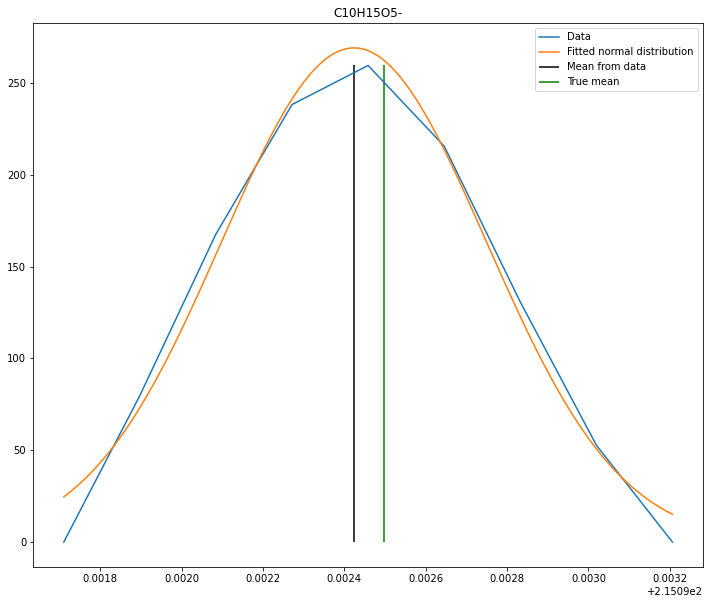

In [35]:
# Plot a peak
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

i = 37
plotPeak(i, peaklist, data)